In [1]:
# importing the necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tqdm import tqdm
import pandas as pd
from skimage.io import imread, imshow
import tensorflow.keras.backend as K
from skimage.transform import resize
import scipy.ndimage
import IPython
from sklearn.preprocessing import StandardScaler
import sklearn.model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from pydicom.data import get_testdata_file
from numpy import asarray
from tensorflow.keras.models import load_model
from pydicom import dcmread
from PIL import Image
%matplotlib inline

In [2]:
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [3]:
def DC(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-DC(y_true, y_pred)

# TEST DATA

In [4]:
base_dir = '/home/kiara/Desktop/CMR_Metric_Calculator/Dataset/Test_PNG/'
test_img_dir = os.path.join(base_dir, 'segment/')
test_label_dir = os.path.join(base_dir, 'all_labels/')

In [5]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNEL = 1
IMG_CHANNELS = 3

In [6]:
# obtaining the training image (and corresponding label (masks)) file names as a list
test_img_fname = os.listdir(test_img_dir)
test_label_fname = test_img_fname

In [7]:
print(len(test_img_fname))
print(len(test_label_fname))

1145
1145


  3%|▎         | 36/1145 [00:00<00:03, 353.70it/s]

Resizing test images


  0%|          | 5/1145 [00:00<00:23, 49.31it/s]

Resizing test images


100%|██████████| 1145/1145 [00:23<00:00, 49.47it/s]


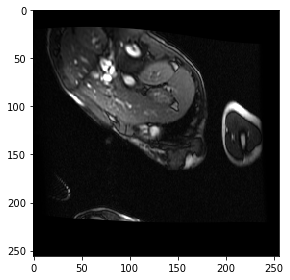

/home/kiara/anaconda3/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


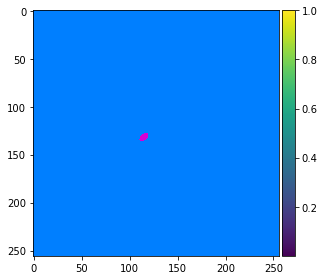

In [8]:
X_test = np.zeros((len(test_img_fname), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL), dtype = np.float32)
sizes_test = []
print("Resizing test images")
for n, id_ in tqdm(enumerate(test_img_fname), total=len(test_img_fname)):
    path = base_dir
    img = imread(test_img_dir + id_) # read the image
    # Uncomment to test on HELIX Dataset
    #img = imread('/media/kiara/My Passport/HELIX/image/' + id_)
    pixels=asarray(img).astype('float32')
    pixels = resize(pixels, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL), mode = 'constant', preserve_range = True)
    
    # convert from integers to floats
    pixels = pixels.astype('float32')
    
    # normalize to the range 0-1
    pixels /= 255.0
    X_test[n] = pixels.astype('float32')
    
Y_test = np.zeros((len(test_label_fname), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.float32)
print("Resizing test images")
from numpy import asarray
from PIL import Image
for n, id_ in tqdm(enumerate(test_img_fname), total=len(test_img_fname)):
    #path = base_dir
    img = imread(test_label_dir + id_) # read the image
    #img = imread('/media/kiara/My Passport/HELIX/label/ShortAxis/' + id_)
    pixels=asarray(img).astype('float32')
    pixels = resize(pixels, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode = 'constant', preserve_range = True)
    
    # convert from integers to floats
    pixels = pixels.astype('float32')
    
    # normalize to the range 0-1
    pixels /= 255.0
    Y_test[n] = pixels.astype('float32')
    
seed = 17
np.random.seed = seed
image_x = random.randint(0, len(test_img_fname)) # generate a random number between 0 and length of training ids
imshow(np.squeeze(X_test[image_x]))
#plt.savefig("image.pdf", format='pdf')
plt.show()

imshow(np.squeeze(Y_test[image_x]))
#plt.savefig("label.pdf", format='pdf')
plt.show()

In [9]:
# importing packages necessary for model training
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tqdm import tqdm
import pandas as pd
from skimage.io import imread, imshow
from skimage.transform import resize
import scipy.ndimage
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import IPython
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from numpy import asarray
from tensorflow import keras
from PIL import Image
import sklearn.model_selection

In [10]:
# defining input layer
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL))
# pixels to floating point numbers
s = tf.keras.layers.Lambda(lambda x: (x/255))(inputs)
print(s)

Tensor("lambda/truediv:0", shape=(None, 256, 256, 1), dtype=float32)


# MODEL 1 : Unet with dropout layers

In [ ]:
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.5)(c1)
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.5)(c2)
c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.5)(c3)
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.5)(c4)
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.5)(c5)
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = tf.keras.layers.Dropout(0.5)(c5)

# Expansion Path
u6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.5)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.5)(c7)
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.5)(c8)
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.5)(c9)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(3, (1,1), activation='sigmoid')(c9)

In [ ]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=[DC, iou_coef, 'acc', precision, recall])
model.summary()

# Model 2: Unet without Dropout Layers

In [ ]:
#Contraction path
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(s)
#c1 = tf.keras.layers.Dropout(0.5)(c1)
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(p1)
#c2 = tf.keras.layers.Dropout(0.5)(c2)
c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(p2)
#c3 = tf.keras.layers.Dropout(0.4)(c3)
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(p3)
#c4 = tf.keras.layers.Dropout(0.5)(c4)
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(p4)
#c5 = tf.keras.layers.Dropout(0.4)(c5)
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c5)
#c5 = tf.keras.layers.Dropout(0.5)(c5)

# Expansion Path
u6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(u6)
#c6 = tf.keras.layers.Dropout(0.4)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(u7)
#c7 = tf.keras.layers.Dropout(0.5)(c7)
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(u8)
#c8 = tf.keras.layers.Dropout(0.5)(c8)
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(u9)
#c9 = tf.keras.layers.Dropout(0.4)(c9)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='tanh', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(3, (1,1), activation='sigmoid')(c9)

In [ ]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=[DC, iou_coef, 'acc', precision, recall])
model.summary()

# Model 3: Residual UNet

In [11]:
# taken directly from the original implementation https://arxiv.org/pdf/1711.10684.pdf
def bn_act(x, act=True):
    x = tf.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tf.keras.layers.Activation("tanh")(x)
        #x = tf.keras.layers.Activation("sigmoid")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = tf.keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = tf.keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = tf.keras.layers.UpSampling2D((2, 2))(x)
    c = tf.keras.layers.concatenate([u, xskip])
    return c

In [12]:
# taken directly from the original implementation https://arxiv.org/pdf/1711.10684.pdf
def ResUNet():
    
    #f = [24, 48, 96, 192, 384]
    #f = [8, 16, 32, 64, 128]
    #f = [64, 128, 256, 512, 1024]
    #f = [8, 16, 32, 64, 128]#1st
    # 16 2nd then 4 3rd
    f = [4, 8, 16, 32, 64]
    
    #f = [32, 64, 128, 256, 512]
    inputs = keras.layers.Input((256, 256, 1))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = keras.layers.Conv2D(3, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

In [13]:
model = ResUNet()
from keras.utils import to_categorical
opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=[DC, iou_coef, 'acc', precision, recall])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 4)  40          input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 4)  16          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 4)  0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Model 4: FCN

In [15]:
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.5)(c1)
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.5)(c2)
c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.5)(c3)
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.5)(c4)
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.5)(c5)
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = tf.keras.layers.Dropout(0.5)(c5)

u6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.5)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.5)(c7)
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.5)(c8)
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.5)(c9)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(3, (1,1), activation='sigmoid')(c9)

In [16]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=[DC, iou_coef, 'acc', precision, recall])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 256, 256, 32) 320         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 32) 0           conv2d_30[0][0]                  
_______________________________________________________________________________________

In [17]:
# load model
segmentation_model = load_model('model_fcn.h5', custom_objects={'DC': DC, 'iou_coef': iou_coef, 'precision': precision, 'recall': recall})
segmentation_model.evaluate(X_test, Y_test)
#print("Accuracy = ", (acc * 100.0), "%")

36/36 [==============================] - 3s 81ms/step - loss: 0.2491 - DC: 0.9977 - iou_coef: 0.7067 - acc: 0.9913 - precision: 1.0000 - recall: 0.9914


[0.24908055365085602,
 0.9976839423179626,
 0.7066737413406372,
 0.9912816286087036,
 1.0,
 0.9913557767868042]

In [18]:
get_ipython().system('tensorboard --logdir=Log_fcn/ --host localhost --port 8000')

2020-12-23 23:10:23.437498: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
TensorBoard 2.4.0 at http://localhost:8000/ (Press CTRL+C to quit)
^C


In [19]:
tensorboard dev upload --logdir \
    'Log_fcn/'

SyntaxError: invalid syntax (<ipython-input-19-c10675e6ecef>, line 1)